In [1]:
from models.merge import CNN, BiLSTM, ELMo
from data.Dataset import Dataset
from data.TrainSet import TrainSet
from data.TestSet import TestSet
from utils.utils import plot_words_cloud, plot_words_count, plot_compare_bars, plot_scores
from utils.constants import BOOKS_DIR

#dtw - distance metric

2021-11-18 13:55:40,389 : INFO : Loading model from ./elmo/...
2021-11-18 13:55:40,391 : INFO : We will cache the vocabulary of 100 tokens.
d:\study\pyenvnn\lib\site-packages\simple_elmo\model.py:529: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
d:\study\pyenvnn\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
d:\study\pyenvnn\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
d:\study\pyenvnn\lib\site-packages\keras\layers\le

Read books

In [2]:
names = ["Furman", "Garshin"]
dataset = Dataset(names)
dataset.data

,label,author,text
0,0,Furman,﻿П. Р. Фурман\nСаардамский плотник\n \n\n184...
1,1,Garshin,﻿Всеволод Михайлович Гаршин\nНадежда Николаев...


Clean text from punctuation

In [3]:
dataset.preprocess()
dataset.data

Preprocessing Garshin: 100%|██████████| 33664/33664 [00:04<00:00, 6898.79it/s]


,label,author,text
0,0,Furman,фурман саардамский плотник глава незнакомец на...
1,1,Garshin,всеволод михайлович гаршин надежда николаевна ...


VISUALIZING THE DATA

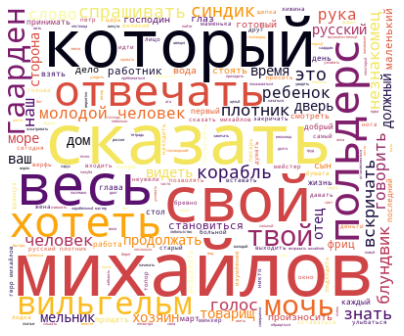

<Figure size 432x288 with 0 Axes>

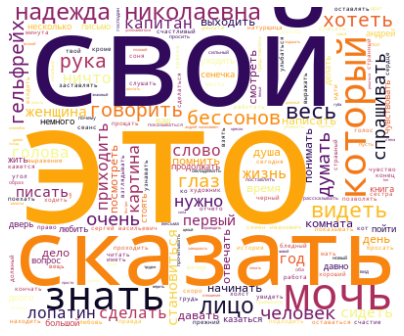

<Figure size 432x288 with 0 Axes>

In [4]:
plot_words_cloud(dataset.data)

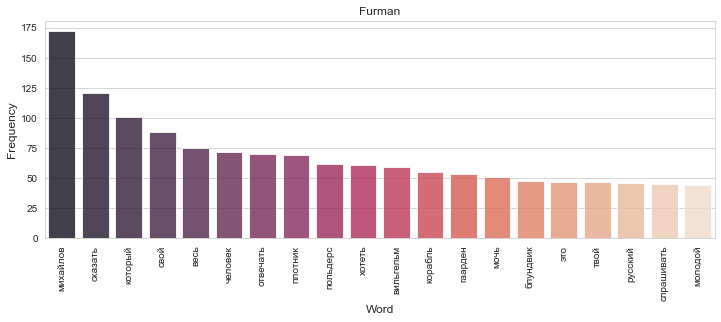

<Figure size 432x288 with 0 Axes>

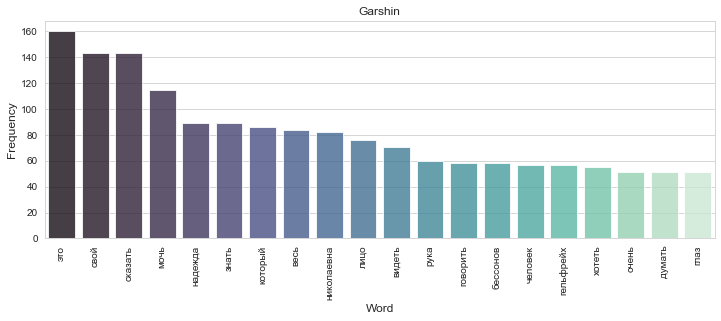

<Figure size 432x288 with 0 Axes>

In [5]:
plot_words_count(dataset.data)

Count and visualize as barplots

d:\study\pyenvnn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


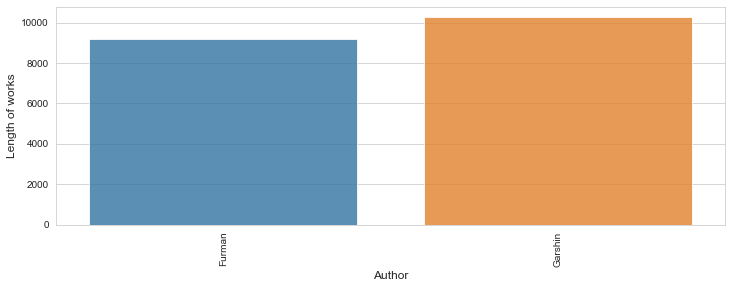

<Figure size 432x288 with 0 Axes>

In [6]:
plot_compare_bars(dataset.data)

In [7]:
dataset.chunking()
dataset.prep_data

,label,author,text
0,0,Furman,"[фурман, саардамский, плотник, глава, незнаком..."
1,0,Furman,"[ровно, набегать, берег, оставлять, каменья, ж..."
2,0,Furman,"[берег, начинать, оживляться, остроконечный, к..."
3,0,Furman,"[черный, масса, полуоконченный, смоленый, судн..."
4,0,Furman,"[узкий, деревянный, лестница, выбеливать, мука..."
...,...,...,...
251,1,Garshin,"[очень, это, жаль, это, рука, надежда, николае..."
252,1,Garshin,"[лицо, глаз, закрывать, неподвижный, чувствова..."
253,1,Garshin,"[оставлять, последний, сила, подымать, полагат..."
254,1,Garshin,"[прибавлять, соня, приезжать, вызывать, телегр..."


In [8]:
dataset.embedding(ELMo)

2021-11-18 13:56:01,329 : INFO : Warming up ELMo on 40 sentences...
2021-11-18 13:56:04,424 : INFO : Warming up finished.
2021-11-18 13:56:04,430 : INFO : Texts in the current batch: 40
2021-11-18 13:56:04,551 : INFO : Texts in the current batch: 40
2021-11-18 13:56:04,673 : INFO : Texts in the current batch: 40
2021-11-18 13:56:04,796 : INFO : Texts in the current batch: 40
2021-11-18 13:56:04,922 : INFO : Texts in the current batch: 40
2021-11-18 13:56:05,044 : INFO : Texts in the current batch: 29
2021-11-18 13:56:11,377 : INFO : Warming up ELMo on 40 sentences...
2021-11-18 13:56:12,027 : INFO : Warming up finished.
2021-11-18 13:56:12,034 : INFO : Texts in the current batch: 40
2021-11-18 13:56:12,162 : INFO : Texts in the current batch: 40
2021-11-18 13:56:12,288 : INFO : Texts in the current batch: 40
2021-11-18 13:56:12,406 : INFO : Texts in the current batch: 40
2021-11-18 13:56:12,530 : INFO : Texts in the current batch: 40
2021-11-18 13:56:12,654 : INFO : Texts in the curren

(485,)

In [9]:
dataset.prep_data

,label,author,text,embeddings
0,0,Furman,"[фурман, саардамский, плотник, глава, незнаком...","[[0.05090406537055969, -0.466616153717041, -0...."
1,0,Furman,"[ровно, набегать, берег, оставлять, каменья, ж...","[[-0.16346460580825806, 0.38957035541534424, 0..."
2,0,Furman,"[берег, начинать, оживляться, остроконечный, к...","[[-0.2622142434120178, 0.17295807600021362, 0...."
3,0,Furman,"[черный, масса, полуоконченный, смоленый, судн...","[[0.3025384545326233, -0.36849087476730347, -0..."
4,0,Furman,"[узкий, деревянный, лестница, выбеливать, мука...","[[0.7458748817443848, 0.10879498720169067, 0.8..."
...,...,...,...,...
251,1,Garshin,"[очень, это, жаль, это, рука, надежда, николае...","[[-0.15286317467689514, -0.5249390602111816, -..."
252,1,Garshin,"[лицо, глаз, закрывать, неподвижный, чувствова...","[[0.36641228199005127, -0.16386733949184418, -..."
253,1,Garshin,"[оставлять, последний, сила, подымать, полагат...","[[0.3695368468761444, 0.10010427236557007, 0.4..."
254,1,Garshin,"[прибавлять, соня, приезжать, вызывать, телегр...","[[0.009572409093379974, 0.5480528473854065, 0...."


In [10]:
train_set = TrainSet(dataset.prep_data)
train_set.shape

,Train,Test
X,"(350, 40, 1024)","(73, 40, 1024)"
Y,"(350,)","(73,)"


In [11]:
cnn = CNN(train_set.X_shape())

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1024)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 38, 200)      614600      ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 37, 200)      819400      ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 36, 200)      1024200     ['input_1[0][0]']                
                                                                                                

In [12]:
bilstm = BiLSTM(train_set.X_shape())

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 1024)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 400)              1960000   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 30)                12030     
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 93        
                                                            

In [13]:
from models.ensemble import Ensemble

cnn_bilstm = Ensemble(cnn, bilstm)

In [14]:
cnn_bilstm.fit(train_set)

NotFoundError: 

In [ ]:
cnn = CNN(train_set.X_shape())

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_set.Y_train, num_classes=3)
y_val = to_categorical(train_set.Y_val, num_classes=3)

# start training
history = cnn.model.fit(train_set.X_train, y_train, epochs=10, batch_size=50, verbose=2,
                        validation_data=(train_set.X_val, y_val))

In [ ]:
cnn.fit(train_set)

In [ ]:
cnn.predict(train_set)

In [ ]:
cnn.confusion_matrix(train_set)

In [ ]:
score_a = cnn.validation(train_set)

In [ ]:
bilstm = BiLSTM(train_set.X_shape(), hidden_state_dim=500)

In [ ]:
bilstm.fit(train_set)

In [ ]:
bilstm.predict(train_set)

In [ ]:
bilstm.confusion_matrix(train_set)

In [ ]:
score_b = bilstm.validation(train_set)

In [ ]:
plot_scores(score_a, score_b)

In [ ]:
if score_a[0] > score_b[0]:
    print("We prefer to choose CNN for this dataset evaluation")
else:
    print("We prefer to choose BiLSTM for this dataset evaluation")

In [ ]:
path = f"{BOOKS_DIR}/Sholokhov/and-quiet-flows-the-don.txt"
testing = TestSet(path, names, ELMo)
testing.dataframe = bilstm.make_prediction(testing)
testing.plot_prediction()